__참조 링크__
- https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c
- https://medium.com/data-science-lab-amsterdam/face-recognition-with-python-in-an-hour-or-two-d271324cbeb3
- https://face-recognition.readthedocs.io/en/latest/_modules/face_recognition/api.html#compare_faces
- https://face-recognition.readthedocs.io/en/latest/_modules/face_recognition/api.html#compare_faces
- https://m.blog.naver.com/PostView.nhn?blogId=kjh3864&logNo=221219146536&proxyReferer=https%3A%2F%2Fwww.google.com%2F

# 필요 package

## cv2
- pip install opencv-python

## dlib
- pip install dlib하면 되는데 error
- 해결 방법
    - https://stackoverflow.com/questions/41912372/dlib-installation-on-windows-10
    - pip install cmake
        - 기존 프로젝트 구성은 특정 IDE나 특정 빌드 도구에 한정되어 하나의 형식으로 한정되게 되는데 (예:visual studio의 sln/vcproj를 다른 플랫폼에서 바로 빌드할 수 없음) 이런 문제점을 CMake를 통해 해결할 수 있음
    - install visual studio build tools
    - In Visual Studio 2017 go to the Individual Components tab, Visual C++ Tools for Cmake, and check the checkbox under the "Compilers, build tools and runtimes" section.
    - pip install dlib
- 근데 난 아래 처럼 진행함
    - visual studio도 깔려 있었어서 그냥 바로 cmake 후 dlib
    - pip install cmake
    - pip install dlib

## openface
- git clone https://github.com/cmusatyalab/openface.git
- cd openface
- pip install -r requirements.txt
- sudo python setup.py install

# 향 후 활용
- 아래에서 임베딩 값을 추출하는 FaceNet 모델에는 이런 정규화 거치지않고
- 여러 밝기와 각도에서의 얼굴 이미지를 input data로 넣고 학습시킴

## 얼굴 정렬(정규화) - Affine Transformation
- 이미지에서 얼굴만 뽑고
- 아핀변환(평행성만 유지한채로 이미지변환)하고

In [213]:
import face_recognition
import dlib
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import openface

print("Start program")

print("Model loading...")

# 랜드마크 찍어주는 model
predictor_model = "./shape_predictor_68_face_landmarks.dat"

# dlib 내장 얼굴 인식용 Hog Face Detector
face_detector = dlib.get_frontal_face_detector()

# 얼굴의 자세를 인식하고 보정해줄 aligner
face_pose_predictor = dlib.shape_predictor(predictor_model)
face_aligner = openface.AlignDlib(predictor_model)

print("Model loading finished.\n")

# 주어진 이미지에서 얼굴을 추출해서 정렬한 후 반환함.
# img는 얼굴을 추출할 이미지, img_dim은 정렬된 이미지(정사각형)의 한 변의 길이.
def align_face(img, img_dim):
    
    # 이미지가 None이 아닌지 체크
    assert img is not None

    detected_faces = face_detector(img, 1)
    
    # 주어진 이미지에서 얼굴이 1개가 맞는지 체크
    assert len(detected_faces) is 1
    # 얼굴 영역
    face_rect = detected_faces[0]

    # 얼굴 랜드마크로 affine transformation
    aligned_face = face_aligner.align(534, img, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

    # 이미지를 사이즈에 맞게 바꿈.
    aligned_face = cv2.resize(aligned_face, (img_dim, img_dim))

    return aligned_face


# 주어진 디렉토리의 모든 이미지를 정렬하여 저장함.
def align_face_dir(dir):
     
    print("Start the image alignment.")
    # 각 경로 단위를 나눔
    path = os.path.split(dir)
    save_path = ''
    for p in path[:-1]:
        save_path = save_path + p + '/'
    save_path = save_path + path[-1] + '_aligned'
    print("Aligned image will be saved at", save_path)

    # 만약 이미 그런 경로가 존재할 경우, 경로를 싹 지워버리고 새로 만듬.
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
        os.mkdir(save_path)
    else:
        os.mkdir(save_path)

    # 전체 이미지 개수
    count_all = 0
    # 그 중에서 오류 없이 처리한 개수
    count_processed = 0
    # dir내의 모든 파일들 돌면서 Affine transformation
    for file in os.listdir(dir):
        count_all += 1
        image = cv2.imread(os.path.join(dir, file))
        try:
            aligned = align_face(image, )
            cv2.imwrite(os.path.join(save_path, file), aligned)
            count_processed += 1
        except AssertionError:
            print("Image processing error :", file)

    # 전체 몇 개 중에서 몇 개가 변환되었는지 출력함.
    print(count_processed, "out of", count_all, "image aligned.\n")


# 위의 함수들을 이용하여 Embedding을 추출할 데이터셋을 만듬.
align_face_dir("./test_images/test1", 96) #김향기
align_face_dir("./test_images/test2", 96) #신뭐시기


Start program
Model loading...
Model loading finished.

Start the image alignment.
Aligned image will be saved at ./test_images/test1_aligned
9 out of 9 image aligned.

Start the image alignment.
Aligned image will be saved at ./test_images/test2_aligned
Image processing error : sin9.jpg
8 out of 9 image aligned.



# 이미지 embedding 후 비교
- [face_recognition api](https://face-recognition.readthedocs.io/en/latest/_modules/face_recognition/api.html#compare_faces)

In [697]:
class Face_Embedding:
    # 생성자에서 db 만듬
    def __init__(self):
        self.create_db()

    def create_db(self):
        self.face_database = {}

    # image가 얼굴을 갖고 있는지 check
    def check_img(self, image_path):
        img_ = cv2.imread(image_path)
        if len(face_recognition.face_locations(img_)) == 0:
            return False
        return True

    # iamge path로 얼굴영역과 embedding 값 받음
    def get_face_embedding(self, image_path, convert_to_rgb=False):
        # 얼굴 없으면 0,0
        print(image_path)
        if not self.check_img(image_path):
            print('얼굴을 찾을 수 없습니다.')
            return 0,0

        image = cv2.imread(image_path)
        # opencv의 경우는 rgb가아닌 bgr의 color이기 때문 근데 출력할거 아니면 안바꿔도 됨
        if convert_to_rgb:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 얼굴 영역 찾고
        face_locations = face_recognition.face_locations(image)
        # 그 영역 통해 embedding된 값
        face_encdoings = face_recognition.face_encodings(image, face_locations)
        # 얼굴영역과, 임베딩된 값 리턴
        return face_locations, face_encdoings

    # setup_db
    def setup_database(self, img_path):
        # setup 성공한 이미지 / 전체 이미지
        totla_image = len(os.listdir(img_path))
        count = 0
        not_face = []

        # ./test_images/test1/ 내의 모든 파일
        for p in os.listdir(img_path):
            # 파일 이름을 key로
            identity = str.split(p, '.')[0]
            print("file {} embedding...".format(p))
            # 해당 이미지 파일 경로를 _img로 해놓고
            img_ = os.path.join(img_path, p)
            # 해당 이미지에대한 embedding값 구해서 encodings에 넣어줌
            _, encodings = self.get_face_embedding(img_, False)
            # 실패한 파일들 볼 수 있도록 append
            if encodings == 0:
                not_face.append(p)
                continue
            elif len(encodings) == 1:
                self.face_database[identity] = encodings[0]
            # 사진에 여러 얼굴 검출되면
            # [array1, array2] 처럼 하나의key에 각 얼굴들의 embedding 값을 넣어 줌
            else:
                self.face_database[identity] = [e for e in encodings]
            # encodings(embedding 값)은 128차원의 특징 값
            count += 1
            print("{} / {}".format(count, totla_image))
        print("얼굴을 못 읽는 이미지 : {}".format(not_face))
        return self.face_database

    # 이미지가 같은지 embedding된 값으로 비교
    # tolerance 이 더 낮으면 엄격함, 0.6을 추천함
    def compare_img(self, img_path, encoding_check_img, tolerance=0.615):
        _, encoding_origin_img = self.get_face_embedding(img_path)
        # 0은 얼굴이 검출되지 않았단 거임
        if encoding_origin_img == 0:
            return False

        distance_diff = []
        # 한 사진에 여러 얼굴이 검출되면 list형태로 저장해서 key에 넣어두기로 해놨었음
        if type(encoding_check_img) is list:
            face_diff = []
            dist_diff = []
            for e in encoding_check_img:
                # 해당 embedding 값들과 비교하고자하는 original image 얼굴의 embedding값 비교
                # face_recognition.face_distance는 내부적으로
                # 두 벡터간의 차를 구하고 그 차에대해 벡터의 길이를 구함
                # 즉 길이가 짧을 수록(값이 작을 수록) 두 얼굴은 일치
                diff = face_recognition.face_distance(encoding_origin_img, e)
                # 벡터간 거리
                dist_diff.append(diff)
                print(diff)
                face_diff.append(list(diff <= tolerance))
            distance_diff.extend(min(dist_diff))
            print(face_diff)

            return distance_diff, [any(list(face_diff))]
        # 한 사진에 한 얼굴만 검출되면 np.array 타입으로 반환하기때문에 바로 비교
        face_diff = face_recognition.face_distance(encoding_origin_img, encoding_check_img)
        print(face_diff)
        distance_diff.append(face_diff)
        return distance_diff, list(face_diff <= tolerance)
        # compare_faces는 내부적으로
        # 128차원의 embedding된 값의 차로 얼굴간의 거리를 구한뒤
        # np.linalg.norm를 통해 128차원의 벡터의 길이를 구함
        # 이길이가 tolerance보다 작을때 두 이미지는 같은 이미지로 간주
        # tolearnace의 값을 높이면 비교연산이 좀더 관대해지게됨

    # 들어온 이미지와 DB를 비교
    def compare_db(self, img_path):
        bool_list = []
        for k in self.face_database.keys():
            _, compare_check = self.compare_img(img_path, test_db[k], 0.62)
            if compare_check:
                print('{}는 {}와 일치합니다'.format(os.path.split(img_path)[-1], k))
            else:
                print('{}는 {}와 불 일치합니다'.format(os.path.split(img_path)[-1], k))

            bool_list.extend(compare_check)
        return bool_list

    # 가장 유사한 이미지 return
    def similar_compare_db(self, img_path):
        diff_list = []
        db_diff = {}
        for i, k in enumerate(self.face_database.keys()):
            db_diff[i] = k
            distance_diff, compare_check = self.compare_img(img_path, test_db[k], 0.62)
            print(distance_diff)
            if compare_check:
                print('{}는 {}와 일치합니다'.format(os.path.split(img_path)[-1], k))
            else:
                print('{}는 {}와 불 일치합니다'.format(os.path.split(img_path)[-1], k))
            diff_list.extend(distance_diff)
        min_diff = np.array(diff_list).argmin()
        print('{}가 {}만큼 가까워서 제일 유사한 얼굴'.format(db_diff[min_diff], diff_list[0]))
        return db_diff[min_diff]

## 테스트

In [698]:
origin_img_path = './test_images/kim1.jpg'
db_image_path = './test_images/test1/'
test1 = Face_Embedding()
test_db = test1.setup_database(db_image_path)

file kim10.jpg embedding...
./test_images/test1/kim10.jpg
1 / 10
file kim2.jpg embedding...
./test_images/test1/kim2.jpg
2 / 10
file kim3.jpg embedding...
./test_images/test1/kim3.jpg
3 / 10
file kim4.jpg embedding...
./test_images/test1/kim4.jpg
4 / 10
file kim5.jpg embedding...
./test_images/test1/kim5.jpg
5 / 10
file kim6.jpg embedding...
./test_images/test1/kim6.jpg
6 / 10
file kim7.jpg embedding...
./test_images/test1/kim7.jpg
7 / 10
file kim8.jpg embedding...
./test_images/test1/kim8.jpg
8 / 10
file kim9.jpg embedding...
./test_images/test1/kim9.jpg
9 / 10
file test1.jpg embedding...
./test_images/test1/test1.jpg
10 / 10
얼굴을 못 읽는 이미지 : []


(49, 141, 101, 89)


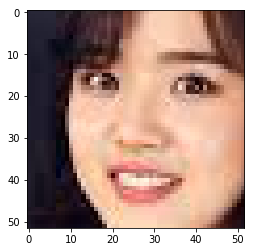

In [699]:
face_rect = get_face_embedding(origin_img_path)[0][0]
print(face_rect)
# lt_y, lt_x, rb_y, rb_x
img = cv2.imread(origin_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
plt.imshow(img[face_rect[0]:face_rect[2], face_rect[3]:face_rect[1]])

In [700]:
print(test_db.keys())
print(test1.compare_img(origin_img_path, test_db['kim2']))

dict_keys(['kim10', 'kim2', 'kim3', 'kim4', 'kim5', 'kim6', 'kim7', 'kim8', 'kim9', 'test1'])
./test_images/kim1.jpg
[0.4222463]
([array([0.4222463])], [True])


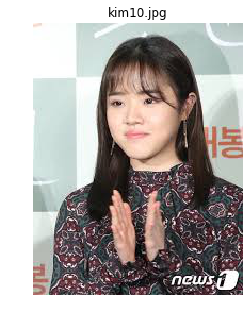

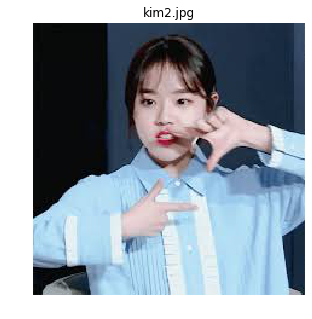

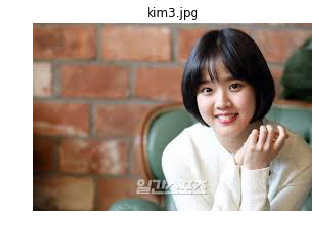

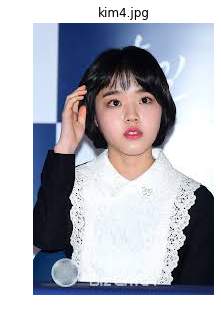

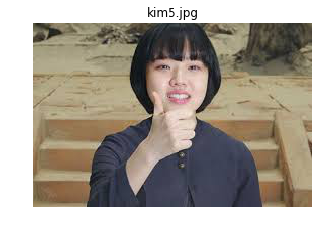

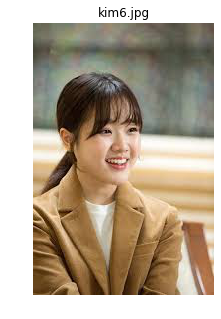

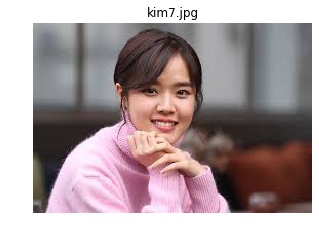

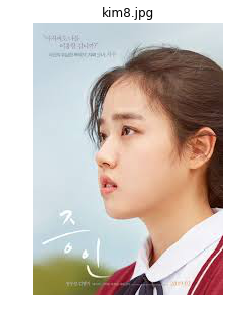

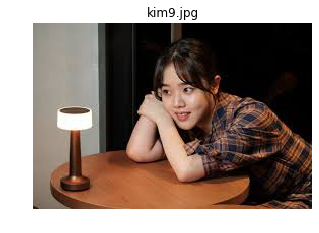

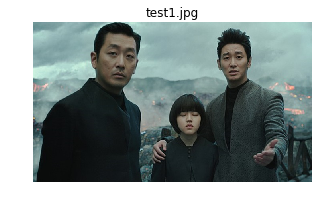

In [706]:
file_list = []
for p in os.listdir(db_image_path):
    image = cv2.imread(os.path.join(db_image_path, p))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    plt.title(p)
    axes.imshow(image, 'gray')
    axes.axis('off')

In [703]:
# def show_pred(img, dots_real, dots_pred):
#     fig, axes = plt.subplots(1, 3, figsize=(10,10))
#     for ax in axes:
#         ax.imshow(, 'gray')
#         ax.axis('off')
        
# # #     points_in = np.vstack(np.split(sample_x[0], 6)).T
# #     points_real = np.vstack(np.split(dots_real[0], 11)).T
# #     points_pred = np.vstack(np.split(dots_pred[0], 11)).T
    
# # #     axes[0].plot(points_in[0], points_in[1], 'o', color='blue')
# #     axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
# #     axes[0].set_title('Predictions', size=16)
    
# # #     axes[1].plot(points_in[0], points_in[1], 'o', color='blue')
# #     axes[1].plot(points_real[0], points_real[1], 'o', color='green')
# #     axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
# #     axes[1].set_title('Both', size=16)
    
# # #     axes[2].plot(points_in[0], points_in[1], 'o', color='blue')
# #     axes[2].plot(points_real[0], points_real[1], 'o', color='yellow')
# #     axes[2].set_title('Real', size=16)

In [704]:
print(test1.similar_compare_db('./test_images/kim1.jpg'))

./test_images/kim1.jpg
[0.33219474]
[array([0.33219474])]
kim1.jpg는 kim10와 일치합니다
./test_images/kim1.jpg
[0.4222463]
[array([0.4222463])]
kim1.jpg는 kim2와 일치합니다
./test_images/kim1.jpg
[0.36277107]
[array([0.36277107])]
kim1.jpg는 kim3와 일치합니다
./test_images/kim1.jpg
[0.33682689]
[array([0.33682689])]
kim1.jpg는 kim4와 일치합니다
./test_images/kim1.jpg
[0.39270078]
[array([0.39270078])]
kim1.jpg는 kim5와 일치합니다
./test_images/kim1.jpg
[0.46461552]
[array([0.46461552])]
kim1.jpg는 kim6와 일치합니다
./test_images/kim1.jpg
[0.36432057]
[array([0.36432057])]
kim1.jpg는 kim7와 일치합니다
./test_images/kim1.jpg
[0.61194706]
[array([0.61194706])]
kim1.jpg는 kim8와 일치합니다
./test_images/kim1.jpg
[0.4141078]
[array([0.4141078])]
kim1.jpg는 kim9와 일치합니다
./test_images/kim1.jpg
[0.68217133]
[0.62129296]
[0.41666448]
[[False], [False], [True]]
[0.41666448300770914]
kim1.jpg는 test1와 일치합니다
kim10가 [0.33219474]만큼 가까워서 제일 유사한 얼굴
kim10
